In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Pre-processamento
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


# Dividindo os dados

from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_validate


# Models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier



In [18]:
df = pd.read_csv('../data/raw/data_titanic.csv')
df_dict = pd.read_csv('../data/external/dictionary.csv')
df_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Variável   15 non-null     object
 1   Descrição  15 non-null     object
 2   Tipo       15 non-null     object
 3   Subtipo    15 non-null     object
 4   Valores    12 non-null     object
dtypes: object(5)
memory usage: 728.0+ bytes


In [19]:
tipos = df_dict['Tipo'].unique()
tipos

array(['Qualitativa', 'Quantitativa', 'Inútil'], dtype=object)

In [20]:
target_variable = 'survived'

useless_variables =  (
    df_dict
    .query("Tipo == 'Inútil'")
    .Variável
    .to_list()
)

nominal_variables = (
    df_dict
    .query("Subtipo == 'Nominal' and Tipo != 'Inútil' and Variável != @target_variable")
    .Variável
    .to_list()
)

ordinal_variables = (
    df_dict
    .query("Subtipo == 'Ordinal' and Tipo != 'Inútil' and Variável != @target_variable")
    .Variável
    .to_list()
)

continuous_variables = (
    df_dict
    .query("Subtipo == 'Contínua' and Tipo != 'Inútil' and Variável != @target_variable")
    .Variável
    .to_list()
)

discrete_variables = (
    df_dict
    .query("Subtipo == 'Discreta' and Tipo != 'Inútil' and Variável != @target_variable")
    .Variável
    .to_list()
)


In [21]:
print(f'Useless: {useless_variables}')
print(f'Nominal: {nominal_variables}')
print(f'Ordinal: {ordinal_variables}')
print(f'Continuous {continuous_variables}')
print(f'Discrete: {discrete_variables}')

Useless: ['embarked', 'class', 'alive']
Nominal: ['sex', 'who', 'adult_male', 'deck', 'embark_town', 'alone']
Ordinal: ['pclass']
Continuous ['age', 'fare']
Discrete: ['sibsp', 'parch']


In [22]:
set(df.columns) - set(nominal_variables+ordinal_variables+discrete_variables+continuous_variables)

{'alive', 'class', 'embarked', 'survived'}

### Pré-processamento

Vamos usar o **SimpleImputer** do Scikit Learn para inserir valores faltantes para os dados do tipo **nominal, ordinal, contínuo**. Para os dados discretos, iremos usar o **KNNImputer**. Por isso, será necessário criar uma estratégia para cada tipo de dado faltante.

In [23]:
# Tratamento para dados faltantes.

nominal_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
ordinal_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
continuous_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
discrete_imputer = KNNImputer(missing_values=np.nan)

Agora, serão criados os Pipelines.  
Nesse momento, iremos unir o tratamento para dados faltantes com a codificação/normalização das variáveis.

In [24]:
nominal_preprocessor = Pipeline(steps=[
    ("missing", nominal_imputer),  # Tratamento de dados faltantes
    ("encoding", OneHotEncoder(sparse_output=False)),  # Codificação de variáveis
])

ordinal_preprocessor = Pipeline(steps=[
    ("missing", ordinal_imputer),
    ("encoding", OrdinalEncoder()),
])

continuous_preprocessor = Pipeline(steps=[
    ("missing", continuous_imputer),
    ("normalization", StandardScaler()),
])

discrete_preprocessor = Pipeline(steps=[
    ("missing", discrete_imputer),
    ("normalization", StandardScaler()),
])

In [25]:
preprocessor = ColumnTransformer([
    ("nominal", nominal_preprocessor, nominal_variables),
    ("ordinal", ordinal_preprocessor, ordinal_variables),
    ("continuous", continuous_preprocessor, continuous_variables),
    ("discrete", discrete_preprocessor, discrete_variables),

])

In [26]:
preprocessor

ColumnTransformer(transformers=[('nominal',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['sex', 'who', 'adult_male', 'deck',
                                  'embark_town', 'alone']),
                                ('ordinal',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('encoding',
                                                  OrdinalEncoder())]),
                                 ['pclass']),
                                ('continuous',
                                 Pipeline(steps=[('missing', SimpleImputer()),
                                                 ('normalization',
                                                  StandardScaler())]),
                                 ['age', 'fare']),
                                ('discrete',
                                 Pipeline(steps=[('missing', KNNImputer()),
                                                 ('normalization',
                                                  StandardScaler())]),
                                 ['sibsp', 'parch'])])

In [27]:
X = df.drop(columns=[target_variable] + useless_variables)
y = df[target_variable]

In [28]:
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)

### Criando os modelos de classificação.

Serão usados os seguintes modelos de classificação:

1. Logistic Regression,
2. KNN Classificador,
3. Random Forest Classifier,
4. SVC (Support Vector Classification),
5. Decision Tree.

Para a amostragem aleatória, será usada a validação cruzada de Monte Carlo.

In [29]:
models = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=5),
    RandomForestClassifier(n_estimators=100, random_state=42),
    SVC(kernel='rbf', C=1.0),
    DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)]

metrics = [
    'accuracy',
    'precision',
    'recall',
    'f1',
    'roc_auc',
]

monte_carlo = ShuffleSplit(n_splits=10, test_size=.2, random_state=11)

In [30]:
results_total = None

for model in models:
    model_name = model.__class__.__name__
    print(f"rodando para o modelo: {model_name}")
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model),
    ])

    scores = cross_validate(
        approach, X, y,
        scoring=metrics,
        cv=monte_carlo
    )


    results_model = pd.DataFrame(scores)
    results_model['model'] = model_name
    if results_total is None:
        results_total = results_model
    else:
        results_total = pd.concat([results_total, results_model])

rodando para o modelo: LogisticRegression
rodando para o modelo: KNeighborsClassifier
rodando para o modelo: RandomForestClassifier
rodando para o modelo: SVC
rodando para o modelo: DecisionTreeClassifier


In [31]:
mean_results = results_total.groupby('model').mean()
mean_results

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
model,,,,,,,
DecisionTreeClassifier,0.018769,0.023291,0.822346,0.777505,0.732374,0.752613,0.845774
KNeighborsClassifier,0.021778,0.028736,0.822905,0.797648,0.701048,0.744575,0.859432
LogisticRegression,0.079990,0.060820,0.833520,0.801523,0.733891,0.764482,0.860402
RandomForestClassifier,0.159183,0.038421,0.830168,0.789150,0.733860,0.759866,0.863655
SVC,0.032537,0.031106,0.831844,0.810817,0.712935,0.757712,0.842008


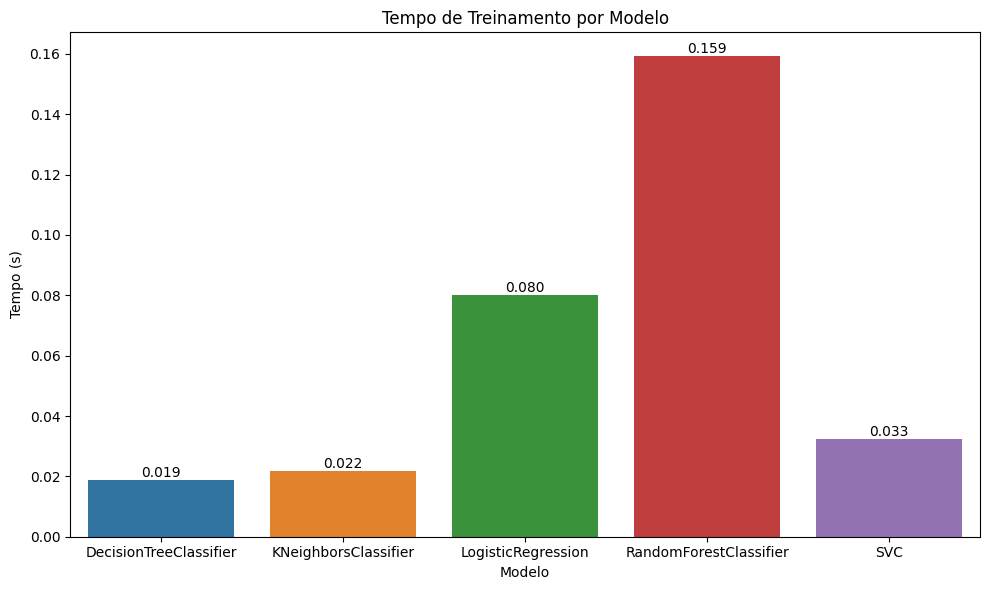

In [47]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mean_results, x=mean_results.index, y='fit_time')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',  # Formatar com 3 casas decimais
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Posição
                ha='center', va='bottom', fontsize=10)
plt.title('Tempo de Treinamento por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Tempo (s)')
plt.tight_layout()
plt.show()

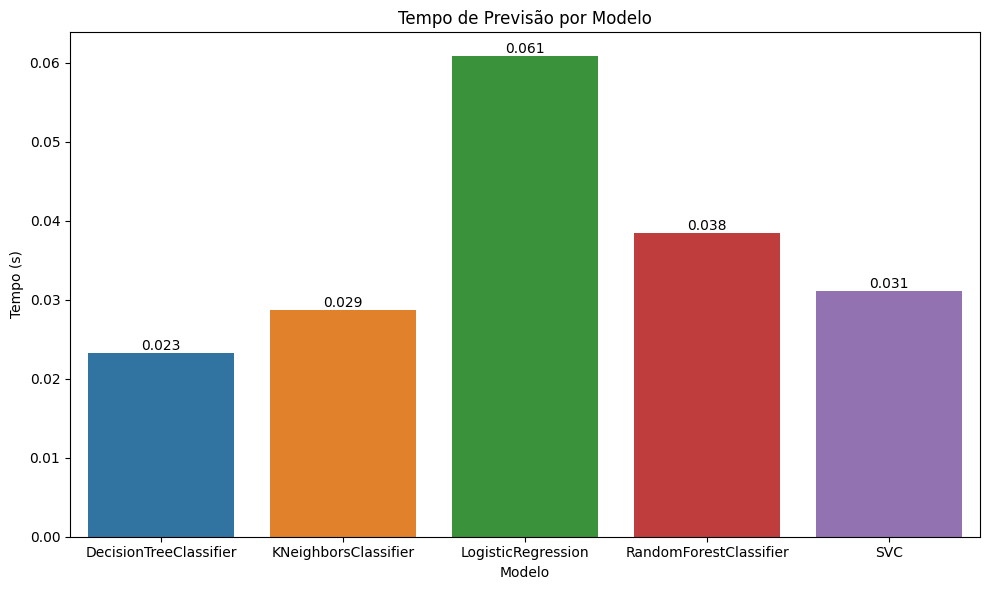

In [48]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=mean_results, x=mean_results.index, y='score_time')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',  # Formatar com 3 casas decimais
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Posição
                ha='center', va='bottom', fontsize=10)
plt.title('Tempo de Previsão por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Tempo (s)')
plt.tight_layout()
plt.show()

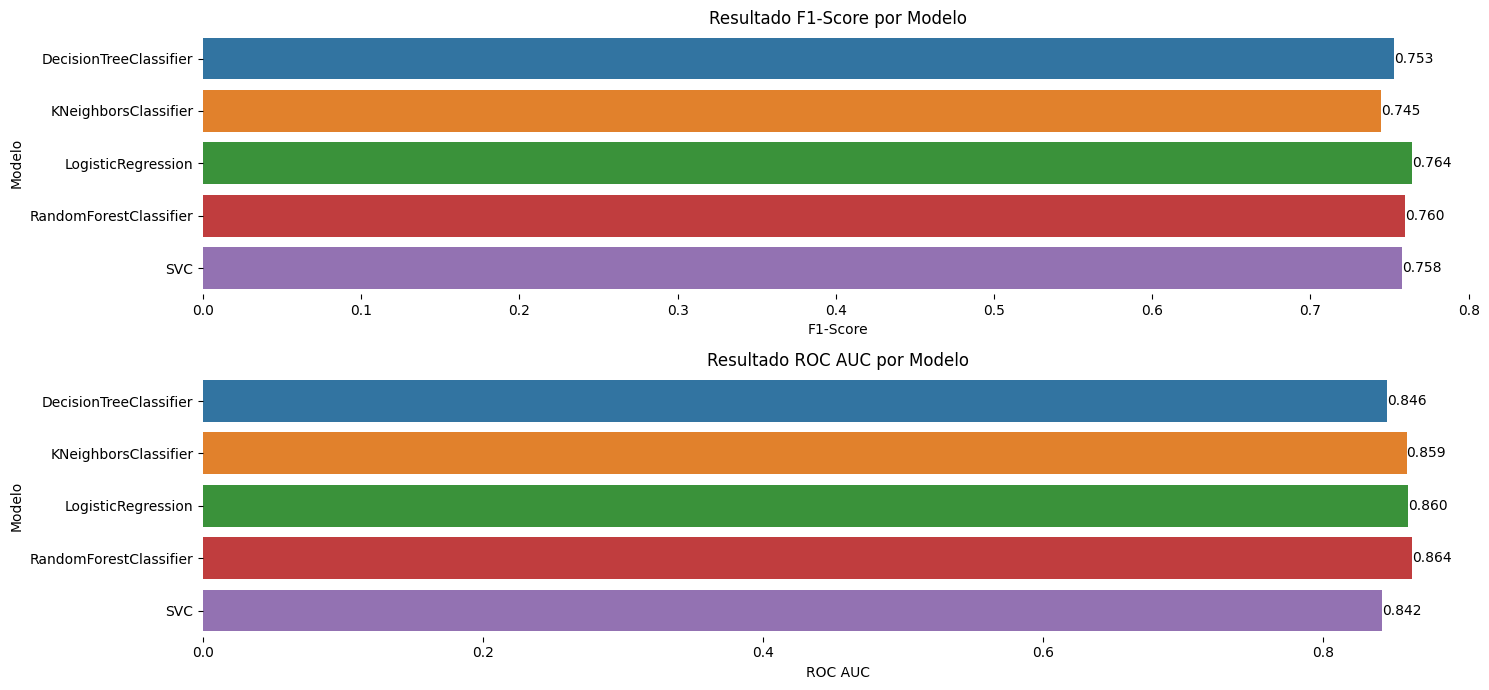

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))

# Gráfico para F1-Score (barras horizontais)
sns.barplot(data=mean_results, x='test_f1', y=mean_results.index, ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{p.get_width():.3f}',  # Formatar com 3 casas decimais
                 (p.get_width(), p.get_y() + p.get_height() / 2),  # Posição
                 ha='left', va='center', fontsize=10)
ax1.set_title('Resultado F1-Score por Modelo')
ax1.set_xlabel('F1-Score')
ax1.set_ylabel('Modelo')

# Remover a borda do gráfico ax1
for spine in ax1.spines.values():
    spine.set_visible(False)


# Gráfico para ROC AUC (barras horizontais)
sns.barplot(data=mean_results, x='test_roc_auc', y=mean_results.index, ax=ax2)
for p in ax2.patches:
    ax2.annotate(f'{p.get_width():.3f}',  # Formatar com 3 casas decimais
                 (p.get_width(), p.get_y() + p.get_height() / 2),  # Posição
                 ha='left', va='center', fontsize=10)
ax2.set_title('Resultado ROC AUC por Modelo')
ax2.set_xlabel('ROC AUC')
ax2.set_ylabel('Modelo')

# Remover a borda do gráfico ax1
for spine in ax2.spines.values():
    spine.set_visible(False)

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [51]:
summary = results_total.groupby('model').agg(['mean', 'std']).T
summary

model                DecisionTreeClassifier  KNeighborsClassifier  \
fit_time       mean                0.018769              0.021778   
               std                 0.001457              0.002712   
score_time     mean                0.023291              0.028736   
               std                 0.001556              0.001923   
test_accuracy  mean                0.822346              0.822905   
               std                 0.027596              0.030033   
test_precision mean                0.777505              0.797648   
               std                 0.055991              0.041678   
test_recall    mean                0.732374              0.701048   
               std                 0.044285              0.059331   
test_f1        mean                0.752613              0.744575   
               std                 0.032799              0.038571   
test_roc_auc   mean                0.845774              0.859432   
               std                 0.031090              0.026451   

model                LogisticRegression  RandomForestClassifier       SVC  
fit_time       mean            0.079990                0.159183  0.032537  
               std             0.020206                0.009790  0.001684  
score_time     mean            0.060820                0.038421  0.031106  
               std             0.018037                0.002378  0.002153  
test_accuracy  mean            0.833520                0.830168  0.831844  
               std             0.024394                0.023585  0.026915  
test_precision mean            0.801523                0.789150  0.810817  
               std             0.063173                0.040532  0.057158  
test_recall    mean            0.733891                0.733860  0.712935  
               std             0.040334                0.051290  0.035960  
test_f1        mean            0.764482                0.759866  0.757712  
               std             0.034222                0.040191  0.035874  
test_roc_auc   mean            0.860402                0.863655  0.842008  
               std             0.026012                0.025113  0.028749